# Titanic Survival Analysis

In the early hours of the morning of 15 April 1912, the RMS Titanic sank on its maiden voyage across the Atlantic Ocean 
after it struck an iceberg. As part of an independent investigation into the tragedy, you are tasked with analysing the
survival logs for passengers aboard the Titanic.

The purpose of this notebook it to use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.

The components of this analysis will include:
1. Exploritory Data Analysis
2. Data Cleaning
3. Data Modeling
4. Data Prediction

## Dataset Description

We have a training and test csv.

For the training set, we have the ground truth of whether each passenger survivors. 
The test set should be used to see how well your model performs on unseen data.


| Variable | Definition | Description |
| --- | --- | --- |
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class (proxy for socio-economic status) | 1 = Upper, 2 = Middle, 3 = Lower |
| sex | Sex of Passemger | male/female |
| Age | Age in years | Integer (Example: 25) |
| sibsp | # of siblings / spouses aboard the Titanic | Integer (Example: 2) |
| parch | # of parents / children aboard the Titanic | Integer (Example: 1) |
| ticket | Ticket number | Str (Example: "SC/Paris 2123") |
| fare | Passenger fare | Float (Example: 41.5792)|
| cabin | Cabin number | Str (Example: "B78")|
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

### Additional Notes

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way..\n
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

In [28]:
# Imports
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

import statsmodels.api as sm
from statsmodels.formula.api import ols, glm

### Load in the data

In [2]:
# Survived
data_dir = "data"
train_path = os.path.join(data_dir, "train.csv")

train_df = pd.read_csv(train_path)
print(f"Train df: {train_df.shape}\n")
train_df.head()

Train df: (891, 12)



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test_path = os.path.join(data_dir, "test.csv")

test_df = pd.read_csv(test_path)
print(f"Test df: {test_df.shape}\n")
test_df.head()

Test df: (418, 11)



,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [6]:
total_data = len(test_df) + len(train_df)
print(f"Train split: {len(train_df)/total_data*100:.0f}%")
print(f"Test split:  {len(test_df)/total_data*100:.0f}%")

Train split: 68%
Test split:  32%


## 1. Expoloritory Data Analysis

### 1.1 Univarient Analysis

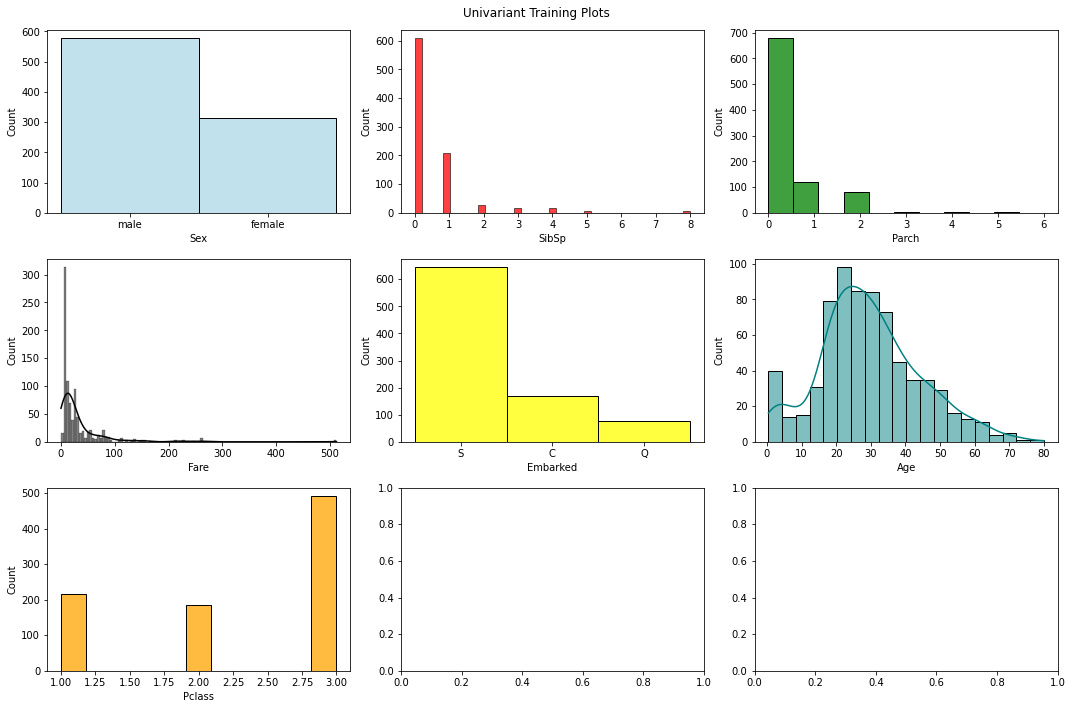

In [7]:
# Univarient Analysis

fig, axs = plt.subplots(3, 3, figsize=(15, 10))

sns.histplot(data=train_df, x="Sex", kde=False, color="lightblue", ax=axs[0, 0])
sns.histplot(data=train_df, x="SibSp", kde=False, color="red", ax=axs[0, 1])
sns.histplot(data=train_df, x="Parch", kde=False, color="green", ax=axs[0, 2])
sns.histplot(data=train_df, x="Fare", kde=True, color="black", ax=axs[1, 0])
sns.histplot(data=train_df, x="Embarked", kde=False, color="yellow", ax=axs[1, 1])
sns.histplot(data=train_df, x="Age", kde=True, color="teal", ax=axs[1, 2])
sns.histplot(data=train_df, x="Pclass", kde=False, color="orange", ax=axs[2, 0])

plt.suptitle("Univariant Training Plots")
plt.tight_layout()
plt.show()

### 1.2 Multivariate Analysis

Text(0.5, 1.05, 'Bar Chart of Survival Rate grouped by Sex')

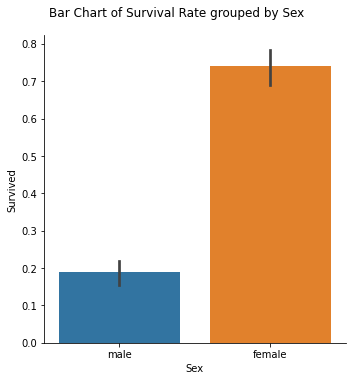

In [8]:
g = sns.catplot(data=train_df, x="Sex", y="Survived", kind="bar")
g.fig.suptitle("Bar Chart of Survival Rate grouped by Sex", y=1.05)

In [9]:
# From the 

In [10]:
for var in list(train_df["Sex"].unique()):
    avg_age = train_df[train_df['Sex']==var]['Age'].mean().round(0)
    print(f"Average age of a {var} passenger:",avg_age)

Average age of a male passenger: 31.0
Average age of a female passenger: 28.0


Text(0.5, 1.05, 'Bar Chart of Survival Rate vs Class grouped by Sex')

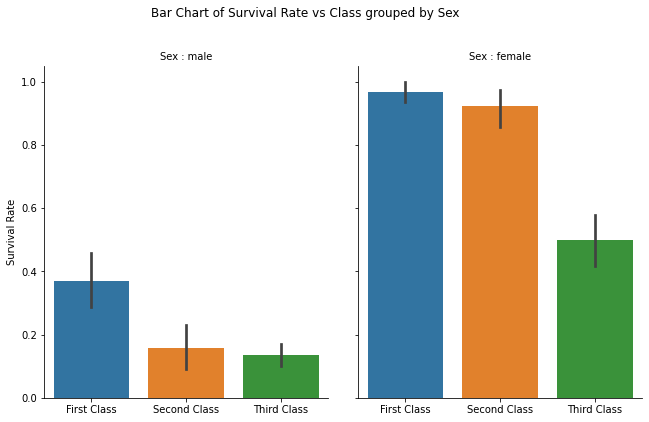

In [11]:
g = sns.catplot(
    data=train_df, x="Pclass", y="Survived", col="Sex",
    kind="bar", height=4, aspect=.6,
)
g.fig.set_size_inches(10,6)
g.set_axis_labels("", "Survival Rate")
g.set_xticklabels(["First Class", "Second Class", "Third Class"])
g.set_titles("{col_var} : {col_name}")
g.fig.suptitle("Bar Chart of Survival Rate vs Class grouped by Sex", y=1.05)

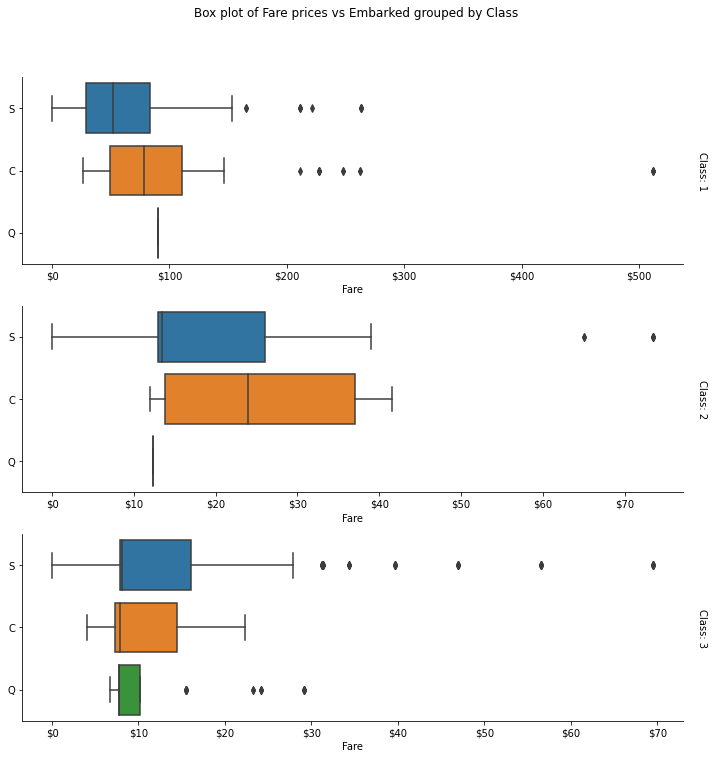

In [12]:
g = sns.catplot(
    data=train_df,
    x="Fare", y="Embarked",
    row="Pclass",
    kind="box", 
    orient="h",
    sharex=False, margin_titles=True,
    height=1.5, aspect=4,
)
g.set(xlabel="Fare", ylabel="")
g.fig.set_size_inches(10,10)
g.set_titles(row_template="Class: {row_name}")
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter('${x:.0f}')
    
g.fig.suptitle("Box plot of Fare prices vs Embarked grouped by Class", y=1.05)
plt.tight_layout()

## 2. Data Cleaning

In [13]:
print(f"Perentage of data null (out of {train_df.shape[0]} rows):")
train_df.isnull().sum() / train_df.shape[0] * 100

Perentage of data null (out of 891 rows):


PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

# Nul Data Result
**Cabin (~77%)**
We see that 77% of Cabin feature is Null. Consider removing the column completely

**Age (~20%)**
We see that the continious variable age is missing 20% of its data. Options:
- Create a model which can predict age using (possibly using [Sex, SibSp, Parch])
- We could just apply the mean age of male or female

**Embarked (>1%)**
- Since this is such a small proportion of the data we can just fill with an aggregate metric (mean) 

In [14]:
# Remove Cabin

train_df.drop(columns="Cabin", inplace=True, errors='ignore')
assert "Cabin" not in train_df.columns

test_df.drop(columns="Cabin", inplace=True, errors='ignore')
assert "Cabin" not in test_df.columns

<AxesSubplot:xlabel='Embarked', ylabel='Count'>

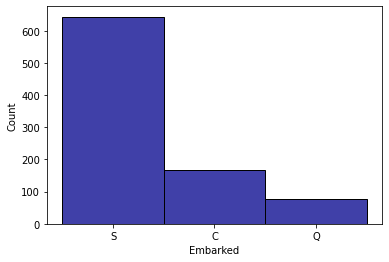

In [15]:
# Fill Embarged with Aggregate

sns.histplot(data=train_df, x="Embarked", kde=False, color="darkblue")

In [16]:
train_df["Embarked"].fillna(value="S", inplace=True)

In [17]:
train_df["Embarked"].isnull().sum()

0

### Predict Age (Sub-prediction task)

Note: We should not use or test data to infer this - but instead create a validation set for tuning this model

Look at most correlated features to base the prediction off

In [18]:
# Drop passenger-id
continious_train_df = train_df.drop(columns="PassengerId")
# Convert Sex to continious data type
sex_cts_dict = {
    'male': 0,
    'female': 1
}
continious_train_df["Sex"] = continious_train_df["Sex"].apply(lambda x: sex_cts_dict[x])

# Convert Embarked to continious data type
embarked_cts_dict = {
    'S': 0,
    'C': 1,
    'Q': 2
}
continious_train_df["Embarked"] = train_df["Embarked"].apply(lambda x: embarked_cts_dict[x])

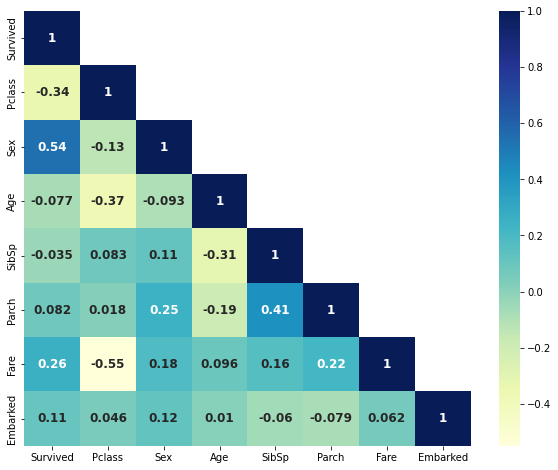

In [19]:
# creating mask
mask = np.triu(np.ones_like(continious_train_df.corr()))
mask[np.diag_indices_from(mask)] = False

fig, ax = plt.subplots(figsize=(10, 8))

# plotting correlation heatmap
a = sns.heatmap(
    continious_train_df.corr(), cmap="YlGnBu", annot=True, mask=mask, ax=ax,
    annot_kws= {'fontsize': 12, 'fontweight': 'bold'}

)
plt.show()

In [20]:
# Write up results an look into Anova

In [22]:
model = ols('Age ~ C(Sex, Sum) * C(Pclass, Sum) ', data=train_df).fit()

# Type 1 ANOVA DataFrame
table_type_1 = sm.stats.anova_lm(model, typ=1) 
table_type_1

,df,sum_sq,mean_sq,F,PR(>F)
"C(Sex, Sum)",1.0,1308.405450,1308.405450,7.372118,6.785730e-03
"C(Pclass, Sum)",2.0,23010.355131,11505.177566,64.825107,1.404675e-26
"C(Sex, Sum):C(Pclass, Sum)",2.0,481.844296,240.922148,1.357459,2.579827e-01
Residual,708.0,125656.031067,177.480270,NaN,NaN


### Result from ANOVA

We see that a combination of Sex and Class is the best predictor if Age. So we will model the Age off these two variables

In [23]:
def predict_age(df):
    null_df = df[df["Age"].isnull()]
    print(null_df.shape)
    non_null_df = df[~df["Age"].isnull()]
    print(non_null_df.shape)
    
    for (sex, pclass), nn_df in non_null_df.groupby(["Sex", "Pclass"]):
        avg_age = int(np.mean(nn_df["Age"]))
        null_df.loc[(null_df["Sex"] == sex) & (null_df["Pclass"] == pclass), "Age"] = avg_age
        print(f"Mean age for {sex}:{pclass} = {avg_age:.2f}")
        
    
    return pd.concat([null_df, non_null_df])
        
        
train_df = predict_age(train_df)
train_df["Age"].isnull().sum()

(177, 11)
(714, 11)
Mean age for female:1 = 34.00
Mean age for female:2 = 28.00
Mean age for female:3 = 21.00
Mean age for male:1 = 41.00
Mean age for male:2 = 30.00
Mean age for male:3 = 26.00


0

## 3. Data Modeling



Fit a logistic regression to the data.

What is a GLM?
A generalized linear model (GLM) is a flexible generalization of ordinary linear regression.

### Task
Build an appropriate logistic regression model of the the data, identifying any variables signicant for the purpose of predicting survival of passengers aboard the Titanic

### Follow Up Question
Using the model to determine if socio-economic status had any bearing on the likelihood of survival for male passengers?

In [59]:
# Binomial Family links: [logit, probit, cauchy, log, loglog, and cloglog]
model_A = glm('Survived ~ Sex + Age + Pclass + Fare', family=sm.families.Binomial(), data=train_df)
result_A = model_A.fit()
print(result_A.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      886
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -400.67
Date:                Sun, 23 Oct 2022   Deviance:                       801.33
Time:                        22:49:51   Pearson chi2:                     946.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3511
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.9717      0.538      9.240      

In [60]:
# Binomial Family links: [logit, probit, cauchy, log, loglog, and cloglog]
model_B = glm('Survived ~ Sex + Age + Pclass + Fare + Sex*Pclass', family=sm.families.Binomial(), data=train_df)
result_B = model_B.fit()
print(result_B.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      885
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -388.20
Date:                Sun, 23 Oct 2022   Deviance:                       776.40
Time:                        22:50:03   Pearson chi2:                 1.17e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3690
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              7.9621      0

# What is deviation?
Deviance is a goodness-of-fit metric for statistical models, particularly used for GLMs.

It is defined as the difference between the Saturated and Proposed Models and can be thought as how much variation in the data does our Proposed Model account for.
Therefore, the lower the deviance, the better the model.

In [61]:
deviance_difference = result_A.deviance - result_B.deviance 
print(f"∆ Deviation between model B and A due to interaction term: {deviance_difference:.3f}")

∆ Deviation between model B and A due to interaction term: 24.930


# Results
**Model A: Survived ~ Sex + Age + Pclass + Fare**

**Model B: Survived ~ Sex + Age + Pclass + Fare + Sex\*Pclass**

Using the table above for model B, we can see that the likelihood of a passengers survival drastically decreases if the passenger is a male as the estimate for Sex(Male) is -6.11
With a estimate of -2.35 for Pclass the socio-economic status of passengers has a direct negative effect on the likelihood of a passengers survival.

Within model B, we see that we have a significant interaction term between Pclass and Sex(Male) which indicates that there is indeed an effect on male passengers of different Pclass levels. To understand the true significance of this interaction term we can compare model A and model B.

We see a ∆Deviance of 24.930 on one degree of freedom while comparing these models which differ by only the interaction term between Pclass and Sex. It is estimated as 1.41 which is a positive interaction effect indicating that makes have a better chance of survival with a small Pclass.

**Conclusion** <br>
Male passengers have an increased survival likelihood with a lower Pclass (A better social-economic standing). This makes sense as a large proportion of the males that survived were from the First Class.

#### Final Model

In [65]:
# Final Model
model_C = glm('Survived ~ Sex+Pclass + Sex*Pclass+ Age*Pclass+ Age*Fare', family=sm.families.Binomial(), data=train_df)
result_C = model_C.fit()
print(result_C.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Survived   No. Observations:                  891
Model:                            GLM   Df Residuals:                      883
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -385.48
Date:                Sun, 23 Oct 2022   Deviance:                       770.96
Time:                        22:59:32   Pearson chi2:                     967.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3728
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              9.3183      1

### Model Checking

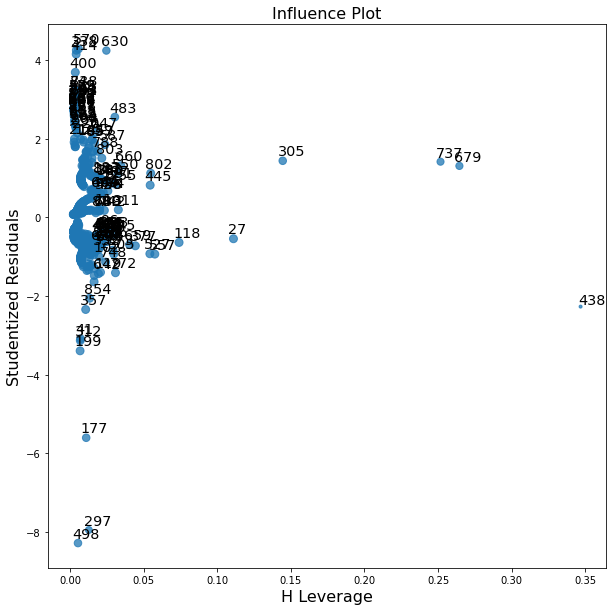

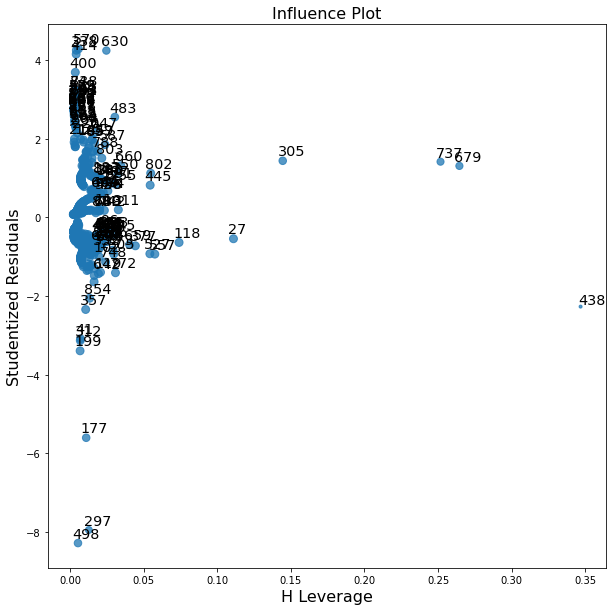

In [92]:
# Plot Observations with high leverage, or large residuals will be labeled in the plot to show potential influence points.

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
influence.plot_influence(size=3, alphafloat=0.5, ax=ax)

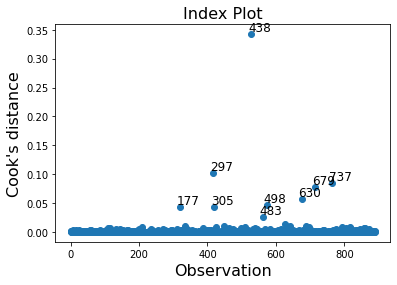

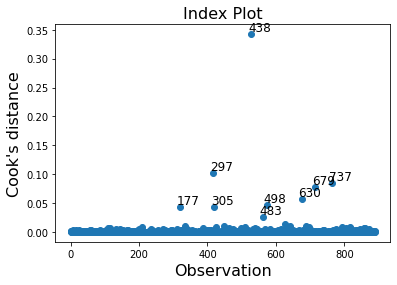

In [88]:
# Plot all observations with a Cook distance of 0.02 or larger to indicate outliers to investigate
influence.plot_index(threshold=0.02)

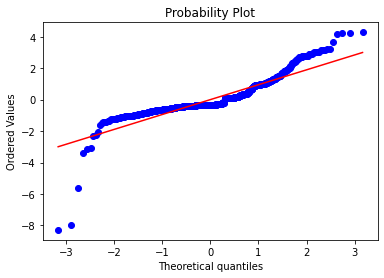

In [97]:
import pylab 
import scipy.stats as stats

measurements = np.random.normal(loc = 20, scale = 5, size=100)   
stats.probplot(influence.resid_studentized, dist="norm", plot=pylab)
pylab.show()

In [ ]:

# Model checking was also performed and no outlines or influential observations were observed according to
# Leverage and Cooks distance.

### Task
Calculate the ratio of the odds of survival for a **First Class** and **Second Class** male passenger aged 25 to the odds of **Third Class** male passengers of the same age and calculate approximate 95% confidence intervals for these statistics.


### Task
Using tree-based methods
i. Fit a default classication tree and plot the tree object (with text).
ii. Why does the tree make sense?
Comment on the relevance of predictors involved in lower tree cuts.

### Question
What fitting phenomenon could this be an example of ?